# Diseñe y desarrolle un modelo y/o script que permita simular el siguiente caso real:
- Obtener datos de tendencia de twitter o facebook(crawler o webscraping), para ello se puede obtener a través del API.
  - Title: Titulo del Post/Twitter
  - Word count: la cantidad de palabras del artículo
  - \# of Links: los enlaces externos que contiene
  - \# of comments: cantidad de comentarios
  - \# Shares: compartidos.
  - HashTag
  - Etc.

- En base a ello, se pretende proponer y generar una predicción de cuántas veces será compartido un post/twitter utilizando regresión.

### Extracción de los tweets

- En el cuaderno de Jupyter 'ExtraccionTweets.ipynb' se encuentra el procedimiento para la extracción de los tweets utilizando la técnica de webscraping.

- Los tweets extraidos relacionados al presidente fueron almacenados en el archivo 'lasso_perfil_tweets.csv'. 

- A continuación se desarrolla el modelo de regresión para la predicción de cuántas veces será compartido un tweet.

## Diseño y desarrollo del modelo de regresión para la predicción 

### Se cargan los datos del archivo 'lasso_perfil_tweets.csv' en un DataFrame.

- Se realiza una limpieza de los tweets sin contenido asociado al texto del tweet.

In [1]:
import pandas as pd
df=pd.read_csv('lasso_perfil_tweets.csv', index_col=False)
df = df[df.Text.notna()]
df.head()

UserName           Handle                 Timestamp  \
0  Guillermo Lasso  @LassoGuillermo  2021-05-29T21:35:01.000Z   
1  Guillermo Lasso  @LassoGuillermo  2021-05-28T23:57:43.000Z   
2  Guillermo Lasso  @LassoGuillermo  2021-05-28T22:23:22.000Z   
3  Guillermo Lasso  @LassoGuillermo  2021-05-26T16:59:31.000Z   
4  Guillermo Lasso  @LassoGuillermo  2021-05-26T15:37:41.000Z   

                                                Text Comments    Likes  \
0  ¡Felicidades \n@MorejonGlenda\n! Ella y más de...       24      153   
1  ¡Una buena noticia!\n@EmbajadaChinaEc\n me inf...      628  1,6 mil   
2  ¡Primera visita a Guayas! Nos reunimos en la G...      134      398   
3  Los invito a acompañarnos en este emotivo even...      108      293   
4                      FAMILIA.\n\n#JuntosLoLogramos      703  1,4 mil   

   Retweets  
0       762  
1  10,5 mil  
2     2 mil  
3   1,1 mil  
4  16,7 mil

### Procesamiento de la información

- Existen valores dentro de la cantidad de comentarios, likes y retweets que contienen el valor abreviado de la cantidad real (ej. 1.6 mil) que realmente es 1600. Es por esto que se reemplaza ese texto por la cantidad de ceros adecuados y se elimina la coma.

- Se realiza el conteo de hashtags utilizados por tweet y se almacena su valor en una columna 'NumHashtags'.
- De la misma manera se cuenta el número de palabras del texto del tweet y el número de links que contenta el tweet.

In [2]:
df.Comments = df.Comments.replace([r'[ mil]+$',','], ['00',''], regex=True)
df.Likes = df.Likes.replace([r'[ mil]+$',','], ['00',''], regex=True)
df.Retweets = df.Retweets.replace([r'[ mil]+$',','], ['00',''], regex=True)
df.Text = df.Text.replace([r'Citar Tweet'], [' Citar Tweet'], regex=True)


df['NumHashtags'] = df.Text.str.findall(r'#.*?(?=\s|$)').str.len()
df['WordCount']= df.Text.apply(lambda x: len(x.split()))
df['NumLinks'] = df.Text.apply(lambda x: 1 if str(x).find('Citar Tweet') != -1 else 0)

df = df.astype({"Comments": float, "Likes": float, "Retweets": float,"NumHashtags": float, "WordCount": float, "NumLinks": float})

In [3]:
df.head()

UserName           Handle                 Timestamp  \
0  Guillermo Lasso  @LassoGuillermo  2021-05-29T21:35:01.000Z   
1  Guillermo Lasso  @LassoGuillermo  2021-05-28T23:57:43.000Z   
2  Guillermo Lasso  @LassoGuillermo  2021-05-28T22:23:22.000Z   
3  Guillermo Lasso  @LassoGuillermo  2021-05-26T16:59:31.000Z   
4  Guillermo Lasso  @LassoGuillermo  2021-05-26T15:37:41.000Z   

                                                Text  Comments   Likes  \
0  ¡Felicidades \n@MorejonGlenda\n! Ella y más de...      24.0   153.0   
1  ¡Una buena noticia!\n@EmbajadaChinaEc\n me inf...     628.0  1600.0   
2  ¡Primera visita a Guayas! Nos reunimos en la G...     134.0   398.0   
3  Los invito a acompañarnos en este emotivo even...     108.0   293.0   
4                      FAMILIA.\n\n#JuntosLoLogramos     703.0  1400.0   

   Retweets  NumHashtags  WordCount  NumLinks  
0     762.0          4.0       69.0       1.0  
1   10500.0          2.0       34.0       0.0  
2     200.0          1.0       33.0       0.0  
3    1100.0          4.0       73.0       1.0  
4   16700.0          1.0        2.0       0.0

### Modelo de regresión lineal

- Se extraen las características de los comentarios, likes, cantidad de hashtags, cantidad de palabras y cantidad de links dentro de la variable x.
- Para la variable y se toman solamente los retweets.


- Se realiza la división de los datos en train y test.
- Se utiliza una regresión lineal.

In [4]:
from sklearn.model_selection import train_test_split  

x = df[['Comments', 'Likes','NumHashtags','WordCount','NumLinks']]
y = df['Retweets'].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42) 

#Training: Regresion Lineal
from sklearn.linear_model import LinearRegression  
regressor = LinearRegression()  
regressor.fit(X_train, y_train) 

b=regressor.intercept_
m=regressor.coef_

### Realizamos predicciones con los datos de prueba y se comparan los datos reales con los datos de las predicciones.

In [5]:
#Haciendo Predicciones: Regresion Lineal
y_pred = regressor.predict(X_test)  

df1 = pd.DataFrame({'Actual': y_test.flatten().astype(float), 'Predicted': y_pred.flatten()}) 

df1 

Actual    Predicted
0   1500.0  1679.162390
1   1700.0  1420.848311
2   4400.0  5331.171275
3    400.0  2005.747228
4    987.0  1299.285088
..     ...          ...
78  1100.0  1516.660907
79  1400.0  1783.527359
80   100.0  1296.193565
81   801.0  1472.544984
82  8100.0  8121.001425

[83 rows x 2 columns]

#### Obtenemos la precisión del modelo

In [6]:
from sklearn.metrics import r2_score
preRF=r2_score(y_test,y_pred)
print("Precisión del modelo: ", preRF)

Precisión del modelo:  0.753892361103545


### Gráfica de los resultados de la regresión frente a los valores reales.

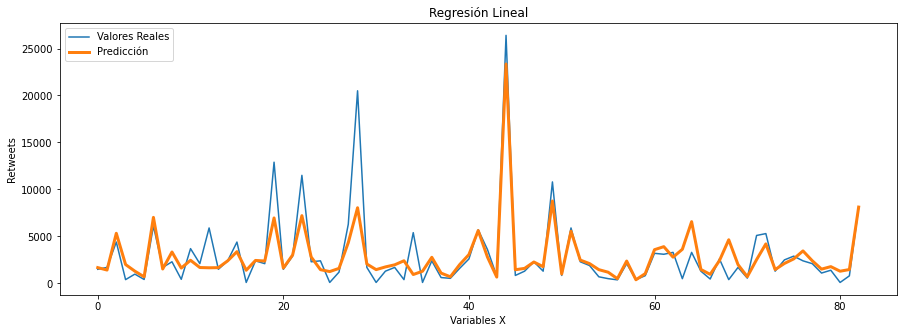

In [9]:
import matplotlib.pyplot as plt  
import numpy as np
plt.figure(figsize = (15,5))

X = np.arange(len(y_test))
y = df['Retweets'].values.reshape(-1,1)

plt.plot(X, df1['Actual'],'-', label ='Valores Reales')
plt.plot(X, df1['Predicted'], '-', label = 'Predicción', linewidth = 3)

plt.title('Regresión Lineal') 
plt.xlabel('Variables X')
plt.ylabel('Retweets')
plt.legend(loc="upper left") 

plt.show()

### Modelo de regresión polinomial

- Extramos nuevamente las caracteristicas para las variables x,y.
- Dividimos los datos para train y para test.
- Usamos una regresión polinomial de grado 4

In [10]:
x = df[['Comments', 'Likes','NumHashtags','WordCount','NumLinks']]
y = df['Retweets'].values.reshape(-1,1)

from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
poly_reg = PolynomialFeatures(degree=4)
X_poly = poly_reg.fit_transform(x)
pol_reg = LinearRegression()
pol_reg.fit(X_poly, y)

LinearRegression()

### Realizamos predicciones con los datos de test. Y se muestra en un DataFrame los valores reales frente a las predicciones obtenidas.

In [11]:
y_pred2 = pol_reg.predict(poly_reg.fit_transform(X_test)) 

df2 = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred2.flatten()}) 
df2

Actual    Predicted
0   1900.0  3068.740865
1   4700.0  4431.008050
2    800.0  3060.959813
3   1900.0   815.662484
4    258.0  2812.103595
..     ...          ...
78  1700.0  1733.060708
79   924.0   766.095909
80  4500.0  2588.356407
81   400.0  4191.935186
82  1500.0   922.860451

[83 rows x 2 columns]

#### Precisión del modelo

In [12]:
from sklearn.metrics import r2_score
preRF=r2_score(y_test,y_pred2)
print("Precisión del modelo: ", preRF)

Precisión del modelo:  0.887370461142778


### Gráfica de la regresión polinomial.

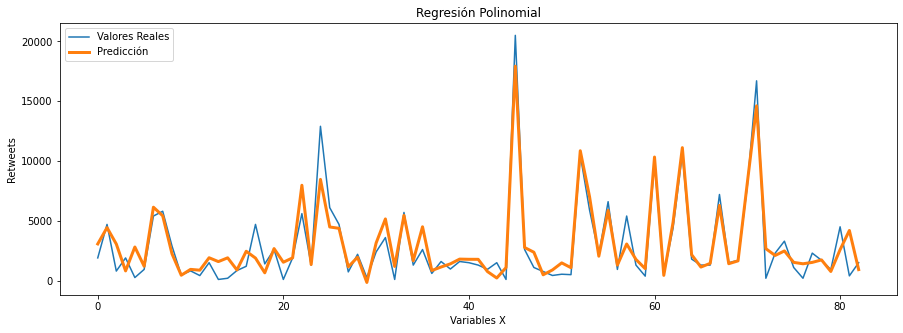

In [13]:
import matplotlib.pyplot as plt  
import numpy as np

plt.figure(figsize = (15,5))

X = np.arange(len(y_test))
y = df['Retweets'].values.reshape(-1,1)

plt.plot(X, df2['Actual'],'-', label ='Valores Reales')
plt.plot(X, df2['Predicted'], '-', label = 'Predicción', linewidth = 3)

plt.title('Regresión Polinomial') 
plt.xlabel('Variables X')
plt.ylabel('Retweets')
plt.legend(loc="upper left") 

plt.show()

## Predicción de las veces que se compartirá un tweet 

In [18]:
# Tweet a predecir
df[200:201]

UserName           Handle                 Timestamp  \
200  Guillermo Lasso  @LassoGuillermo  2021-04-02T12:36:19.000Z   

                                                  Text  Comments   Likes  \
200  En el Chimborazo con mi esposa. \n\nGracias po...     100.0  1400.0   

     Retweets  NumHashtags  WordCount  NumLinks  
200    9800.0          1.0       19.0       0.0

In [19]:
xTest = df[200:201][['Comments', 'Likes','NumHashtags','WordCount','NumLinks']]
print('Predicción regresión lineal:', regressor.predict(xTest))

Predicción regresión lineal: [[5495.56863182]]


In [20]:
print('Predicción regresión polinomial: ',pol_reg.predict(poly_reg.fit_transform(xTest)))

Predicción regresión polinomial:  [[9321.12251108]]


---------------------

In [21]:
# Tweet a predecir
df[414:415]

UserName           Handle                 Timestamp  \
416  Guillermo Lasso  @LassoGuillermo  2021-02-07T19:47:57.000Z   

                                                  Text  Comments  Likes  \
416  ¡SEGUIMOS! \n\nÚnete al Informativo CAMBIO 202...      53.0  108.0   

     Retweets  NumHashtags  WordCount  NumLinks  
416     537.0          2.0       34.0       0.0

In [22]:
xTest2 = df[414:415][['Comments', 'Likes','NumHashtags','WordCount','NumLinks']]

In [23]:
print('Predicción regresión lineal:', regressor.predict(xTest2))

Predicción regresión lineal: [[702.30822608]]


In [24]:
print('Predicción regresión polinomial: ',pol_reg.predict(poly_reg.fit_transform(xTest2)))

Predicción regresión polinomial:  [[1483.6097745]]
